# Building Pulse Instructions

Pulse programs, which are called `Schedule`s, describe instruction sequences for the control electronics.

On this page, we will cover in depth these `Instruction`s available through Qiskit Pulse:

 - [`Delay(duration: int, channel)`](#delay)
 - [`Play(pulse, channel)`](#play)
 - [`SetFrequency(frequency, channel)`](#frequency)
 - [`ShiftPhase(phase, channel)`](#phase)
 - [`Acquire(duration, channel, mem_slot, reg_slot)`](#acquire)

Each instruction type has its own set of operands. As you can see above, they each include at least one `Channel` to specify where the instruction will be applied.

**Channels** are labels for signal lines from the control hardware to the quantum chip.

 - `DriveChannel`s are typically used for _driving_ single qubit rotations,
 - `ControlChannel`s are typically used for multi-qubit gates or additional drive lines for tunable qubits, 
 - `MeasureChannel`s are specific to transmitting pulses which stimulate readout, and
 - `AcquireChannel`s are used to trigger digitizers which collect readout signals.
 
`DriveChannel`s, `ControlChannel`s, and `MeasureChannel`s are all `PulseChannel`s; this means that they support _transmitting_ pulses, whereas the `AcquireChannel` is a receive channel only and cannot play waveforms.

For the following examples, we will create one `DriveChannel` instance for each `Instruction` that accepts a `PulseChannel`. Channels take one integer `index` argument. Except for `ControlChannel`s, the index maps trivially to the qubit label.

In [1]:
from qiskit.pulse import DriveChannel

channel = DriveChannel(0)

<a id='delay'></a>
## `Delay`

One of the simplest instructions we can build is `Delay`. This is a blocking instruction that tells the control electronics to output no signal on the given channel for the duration specified. It is useful for controlling the timing of other instructions.

The duration here and elsewhere is in terms of the backend's cycle time (1 / sample rate), `dt`.

To build a `Delay` instruction, we pass the duration and channel:

In [2]:
from qiskit.pulse import Delay

delay_5dt = Delay(5, channel)

where `channel` can be any kind of channel, including `AcquireChannel`.

That's all there is to it. This instruction, `delay_5dt`, is ready to be included in a `Schedule`. Any instruction appended after `delay_5dt` on the same channel will execute five timesteps later than it would have without this delay.

<a id='play'></a>
## `Play`

The `Play` instruction is responsible for executing _pulses_. It's straightforward to build one:

```
play = Play(pulse, channel)
```

Let's clarify what the `pulse` argument is and explore a few different ways to build one.

### Pulses

A `Pulse` specifies an arbitrary pulse _envelope_. The modulation frequency and phase of the output waveform are controlled by the `SetFrequency` and `ShiftPhase` instructions, which we will cover next.

The image below may provide some intuition for why they are specified separately. Think of the pulses which describe their envelopes as input to an arbitrary waveform generator (AWG), a common lab instrument -- this is depicted in the left image. Notice the limited sample rate discritizes the signal. The signal produced by the AWG may be mixed with a continuous sine wave generator. The frequency of its output is controlled by instructions to the sine wave generator; see the middle image. Finally, the signal sent to the qubit is demonstrated by the right side of the image below.

**Note**: The hardware may be implemented in other ways, but if we keep the instructions separate, we avoid losing explicit information, such as the value of the modulation frequency.

![alt text](pulse_modulation.png "Pulse modulation image")

There are many methods available to us for building up pulses. Our `library` within Qiskit Pulse contains helpful methods for building `Pulse`s. Let's take for example a simple Gaussian pulse -- a pulse with its envelope described by a sampled Gaussian function. We arbitrarily choose an amplitude of 1, standard deviation $\sigma$ of 10, and 128 sample points.

**Note**: The maximum amplitude allowed is `1.0`. Most systems also have additional constraints on the minimum and maximum number of samples allowed in a pulse. These additional constraints, if available, would be provided through the `BackendConfiguration` which is described [here](5_gathering_system_information.ipynb#Configuration).

In [3]:
from qiskit.pulse import library

amp = 1
sigma = 10
num_samples = 128

#### Parametric pulses
Let's build our Gaussian pulse using the `Gaussian` parametric pulse. A parametric pulse sends the name of the function and its parameters to the backend, rather than every individual sample. Using parametric pulses makes the jobs you send to the backend much smaller. IBM Quantum backends limit the maximum job size that they accept, so parametric pulses may allow you to run larger programs.

Other parametric pulses in the `library` include `GaussianSquare`, `Drag`, and `ConstantPulse`.

**Note**: The backend is responsible for deciding exactly how to sample the parametric pulses. It is possible to draw parametric pulses, but the samples displayed are not guaranteed to be the same as those executed on the backend.

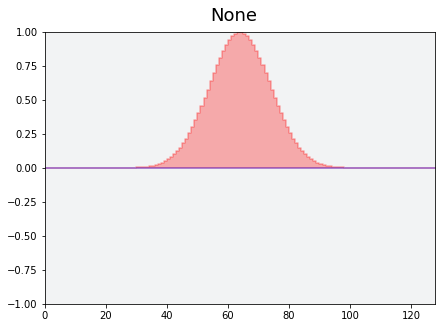

In [4]:
pulse = library.Gaussian(num_samples, amp, sigma, name="Parametric Gaus")
pulse.draw()

**Pulse waveforms described by samples**

It is also possible to specify the waveform as an array of samples. We pass the samples to a `Waveform`.

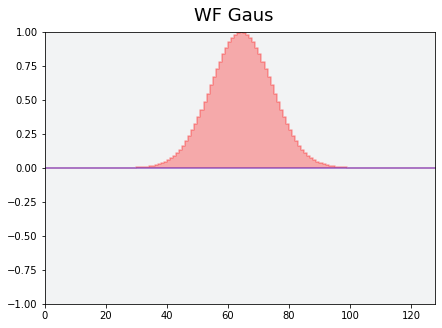

In [5]:
import numpy as np

times = np.arange(num_samples)
gaussian_samples = np.exp(-1/2 *((times - num_samples / 2) ** 2 / sigma**2))

pulse = library.Waveform(gaussian_samples, name="WF Gaus")
pulse.draw()

**Pulse library functions**

Our own pulse library has sampling methods to build `Waveforms`s from common functions.

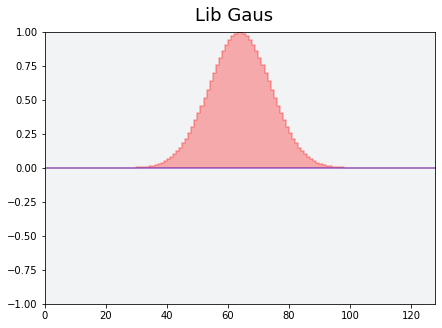

In [6]:
pulse = library.gaussian(duration=num_samples, amp=amp, sigma=sigma, name="Lib Gaus")
pulse.draw()

#### External libraries

Alternatively, you can make use of an external library.

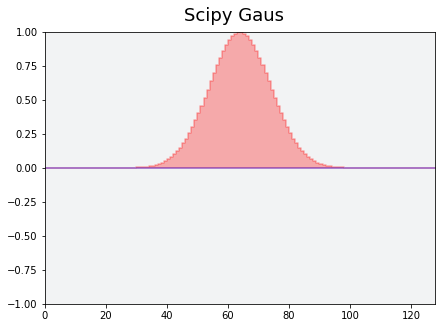

In [7]:
from scipy import signal

sampled_gaussian_envelope = signal.gaussian(num_samples, sigma)
pulse = library.Waveform(sampled_gaussian_envelope, name="Scipy Gaus")
pulse.draw()

Regardless of which method you use to specify your `pulse`, `Play` is instantiated the same way:

In [8]:
from qiskit.pulse import Play


play_gaus = Play(pulse, channel)

The `Play` instruction gets its duration from its `Pulse`: the duration of a parametrized pulse is an explicit argument, and the duration of a `Waveform` is the number of input samples.

<a id='frequency'></a>
## `SetFrequency`

As explained previously, the output pulse waveform envelope is also modulated by a frequency and phase. Each channel has a [default frequency listed in the `backend.defaults()`](5_gathering_system_information.ipynb#Defaults).

The frequency of a channel can be updated at any time within a `Schedule` by the `SetFrequency` instruction. It takes a float `frequency` and a `PulseChannel` `channel` as input. All pulses on a channel following a `SetFrequency` instruction will be modulated by the given frequency until another `SetFrequency` instruction is encountered or until the program ends.

The instruction has an implicit duration of `0`. 

**Note**: The frequencies that can be requested are limited by the total bandwidth and the instantaneous bandwidth of each hardware channel. In the future, these will be reported by the `backend`.

In [9]:
from qiskit.pulse import SetFrequency

set_freq = SetFrequency(4.5e9, channel)

<a id='phase'></a>
## `ShiftPhase`

The `ShiftPhase` instruction will increase the phase of the frequency modulation by `phase`. Like `SetFrequency`, this phase shift will affect all following instructions on the same channel until the program ends. To undo the affect of a `ShiftPhase`, the negative `phase` can be passed to a new instruction.

Like `SetFrequency`, the instruction has an implicit duration of `0`.

In [10]:
from qiskit.pulse import ShiftPhase

phase_pi = ShiftPhase(np.pi, channel)

## `Acquire`
The `Acquire` instruction triggers data acquisition for readout. It takes a duration, an `AcquireChannel` which maps to the qubit being measured, and a `MemorySlot` or a `RegisterSlot`. The `MemorySlot` is classical memory where the readout result will be stored. The `RegisterSlot` maps to a register in the control electronics which stores the readout result for fast feedback.

`Acquire` instructions can also take custom `Discriminator`s and `Kernel`s as keyword arguments. Read more about building measurements [here](4_adding_measurements.ipynb).

In [11]:
from qiskit.pulse import Acquire, AcquireChannel, MemorySlot

acquire = Acquire(1200, AcquireChannel(0), MemorySlot(0))

Now that we know how to build instructions, let's learn how to compose them into `Schedule`s on the [next page](3_building_pulse_schedules.ipynb)!

In [12]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright